# lib

In [60]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, ConvLSTM1D, Conv1D, Concatenate
from tensorflow.keras.layers import LSTM , BatchNormalization

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
!pip install pandas_ta
import pandas_ta as ta

     |████████████████████████████████| 115 kB 5.1 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=9d12189ab8ffbe8d29be2b7350dfef7f004814be0174ea39dd5fd3072326f5b0
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


# preprocessing data

In [3]:
# https://www.kaggle.com/datasets/paulrohan2020/bitcoin-historic-prices-from-oct2015-to-oct2021?select=btc_ohlc_Oct_2015_to_Oct_2021.csv
from google.colab import drive
drive.mount('/content/drive')
path_to_file = "./drive/MyDrive/btc_ohlc_Oct_2015_to_Oct_2021.csv"

Mounted at /content/drive


In [4]:
btc_input_df = pd.read_csv(path_to_file)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [5]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})
btc_input_df_datetype['close_log'] = np.log(btc_input_df_datetype['close'])

In [6]:
btc_input_df_datetype.drop(2381238,axis=0,inplace=True)
btc_input_df_datetype['close_log'][btc_input_df_datetype['close']<4]

Series([], Name: close_log, dtype: float64)

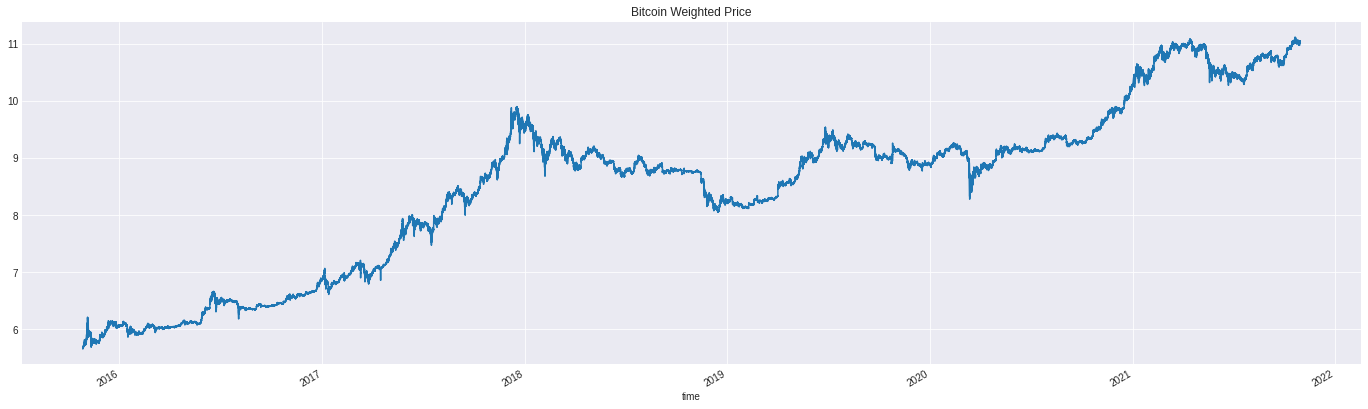

In [7]:
# btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")
btc_input_df_datetype.set_index("time").close_log.plot(figsize=(24,7), title="Bitcoin Weighted Price")

In [8]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close_log'].mean()

display(btc_closing_price_groupby_date.head(10))

,time,low,high,open,close,volume,close_log,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,11.033598,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,11.032997,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,11.033326,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,11.032490,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,11.032989,2021-10-30


date
2015-10-27    5.679741
2015-10-28    5.710364
2015-10-29    5.738202
2015-10-30    5.788838
2015-10-31    5.780111
2015-11-01    5.766747
2015-11-02    5.826106
2015-11-03    5.957086
2015-11-04    6.107486
2015-11-05    5.991228
Name: close_log, dtype: float64

In [24]:
btc = pd.DataFrame()
btc['close_log'] =  group['close_log'].mean()
# btc['diff1_log'] = btc['close_log'].diff(1)
# btc['diff7_log'] = btc['close_log'].diff(7)
# btc['diff20_log'] = btc['close_log'].diff(20)
# btc['diff50_log'] = btc['close_log'].diff(50)
# btc['diff100_log'] = btc['close_log'].diff(100)
# btc['diff200_log'] = btc['close_log'].diff(200)
# btc['high'] =  group['high'].mean()
# btc['low'] =  group['low'].mean()
btc['close'] =  group['close'].mean()
# btc['diff1'] = btc['close'].diff(1)
# btc['diff7'] = btc['close'].diff(7)
# btc['diff30'] = btc['close'].diff(30)
# btc['diff60'] = btc['close'].diff(60)
# btc['diff100'] = btc['close'].diff(100)
# btc['diff200'] = btc['close'].diff(200)
# btc['diff400'] = btc['close'].diff(400)
# btc['diff600'] = btc['close'].diff(600)
# btc['reverse_diff'] = btc['close'].shift(1) + btc['diff']

# dema, ema, fwma, hma, linreg, midpoint, pwma, rma,
# sinwma, sma, swma, t3, tema, trima, vidya, wma, zlma
# btc['ema20_clog'] = ta.ma("ema", btc['close_log'], length=20)
# btc['ema50_clog'] = ta.ma("ema", btc['close_log'], length=50)
# btc['ema100_clog'] = ta.ma("ema", btc['close_log'], length=100)
# btc['ema200_clog'] = ta.ma("ema", btc['close_log'], length=200)
# btc['ema400_clog'] = ta.ma("ema", btc['close_log'], length=400)
# btc['ema600_clog'] = ta.ma("ema", btc['close_log'], length=600)

# btc['ema20'] = ta.ma("ema", btc['close'], length=20)
# btc['ema50'] = ta.ma("ema", btc['close'], length=50)
# btc['ema100'] = ta.ma("ema", btc['close'], length=100)
# btc['ema200'] = ta.ma("ema", btc['close'], length=200)
# btc['ema300'] = ta.ma("ema", btc['close'], length=300)
# btc['ema400'] = ta.ma("ema", btc['close'], length=400)
# btc['ema600'] = ta.ma("ema", btc['close'], length=600)

# btc['mom10'] = ta.mom(btc['close'],length=10)
# btc['mom30'] = ta.mom(btc['close'],length=30)
# btc['mom60'] = ta.mom(btc['close'],length=60)
# btc['mom90'] = ta.mom(btc['close'],length=90)

# btc['atr10'] = ta.atr(btc.high, btc.low, btc.close, length=10)
# btc['atr30'] = ta.atr(btc.high, btc.low, btc.close, length=30)
# btc['atr60'] = ta.atr(btc.high, btc.low, btc.close, length=60)
# btc['atr90'] = ta.atr(btc.high, btc.low, btc.close, length=90)

# btc['rsi14'] = ta.rsi(btc['close'],length=14)
# btc['rsi30'] = ta.rsi(btc['close'],length=30)
# btc['rsi60'] = ta.rsi(btc['close'],length=60)
# btc['rsi90'] = ta.rsi(btc['close'],length=90)


# stoch =ta.stoch(btc.high, btc.low, btc.close)
# stoch = stoch['STOCHd_14_3_3']-stoch['STOCHk_14_3_3']
# btc['stoch'] = stoch

# btc['adx'] = ta.adx(btc.high, btc.low, btc.close, length=30)['ADX_30']


btc['target_log'] = btc['close_log'].shift(-1)
btc['target'] = btc['close'].shift(-1)
btc = btc.dropna()
# btc.drop('close', axis=1, inplace=True)

In [25]:
btc.tail()

,close_log,close,target_log,target
date,,,,
2021-10-25,11.044651,62611.015403,11.039727,62304.201403
2021-10-26,11.039727,62304.201403,10.993767,59508.951285
2021-10-27,10.993767,59508.951285,11.006138,60252.358194
2021-10-28,11.006138,60252.358194,11.028101,61584.211944
2021-10-29,11.028101,61584.211944,11.035381,62030.562210


In [26]:
df_corr = btc.corr()
df_corr

,close_log,close,target_log,target
close_log,1.000000,0.788101,0.999735,0.787837
close,0.788101,1.000000,0.787924,0.999057
target_log,0.999735,0.787924,1.000000,0.788322
target,0.787837,0.999057,0.788322,1.000000


In [27]:
with open('./drive/MyDrive/btc.moh','wb') as f :
    pickle.dump(btc,f)

# Load data

In [32]:
from google.colab import drive
drive.mount('/content/drive')
with open('./drive/MyDrive/btc.moh','rb') as f :
    btc = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
btc.head(2)

,close_log,close,target_log,target
date,,,,
2015-10-27,5.679741,292.887484,5.710364,301.991834
2015-10-28,5.710364,301.991834,5.738202,310.537530


In [31]:
btc.columns 

Index(['close_log', 'close', 'target_log', 'target'], dtype='object')

In [16]:
btc = btc[:][-516:]

In [33]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# StandardScaler
scaler = StandardScaler()

scaler_t = StandardScaler()
btc.close = scaler_t.fit_transform(btc.close.values.reshape(-1,1))
btc.target = scaler_t.fit_transform(btc.target.values.reshape(-1,1))

scaler_tlog = StandardScaler()
btc.close_log = scaler_tlog.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler_tlog.transform(btc.target_log.values.reshape(-1,1))


# scaler_high = StandardScaler()
# btc.high = scaler_high.fit_transform(btc.high.values.reshape(-1,1))

# scaler_low = StandardScaler()
# btc.low = scaler_low.fit_transform(btc.low.values.reshape(-1,1))


# scaler_diff1_log = StandardScaler()
# btc.diff1_log = scaler_diff1_log.fit_transform(btc.diff1_log.values.reshape(-1,1))

# scaler_diff7_log = StandardScaler()
# btc.diff7_log = scaler_diff7_log.fit_transform(btc.diff7_log.values.reshape(-1,1))

# scaler_diff30_log = StandardScaler()
# btc.diff30_log = scaler_diff30_log.fit_transform(btc.diff30_log.values.reshape(-1,1))




# scaler_diff = StandardScaler()
# btc.diff7 = scaler_diff.fit_transform(btc.diff7.values.reshape(-1,1))

# btc.diff30 = scaler_diff.transform(btc.diff30.values.reshape(-1,1))

# btc.diff60 = scaler_diff.transform(btc.diff60.values.reshape(-1,1))

# btc.diff100 = scaler_diff.transform(btc.diff100.values.reshape(-1,1))

# btc.diff200 = scaler_diff.transform(btc.diff200.values.reshape(-1,1))

# btc.diff400 = scaler_diff.transform(btc.diff400.values.reshape(-1,1))

# btc.diff600 = scaler_diff.transform(btc.diff600.values.reshape(-1,1))





# btc.ema20_clog = scaler_tlog.transform(btc.ema20_clog.values.reshape(-1,1))

# btc.ema50_clog = scaler_tlog.transform(btc.ema50_clog.values.reshape(-1,1))

# btc.ema100_clog = scaler_tlog.transform(btc.ema100_clog.values.reshape(-1,1))

# btc.ema200_clog = scaler_tlog.transform(btc.ema200_clog.values.reshape(-1,1))

# btc.ema400_clog = scaler_tlog.transform(btc.ema400_clog.values.reshape(-1,1))

# btc.ema600_clog = scaler_tlog.transform(btc.ema600_clog.values.reshape(-1,1))




# btc.ema20 = scaler_t.transform(btc.ema20.values.reshape(-1,1))

# btc.ema50 = scaler_t.transform(btc.ema50.values.reshape(-1,1))

# btc.ema100 = scaler_t.transform(btc.ema100.values.reshape(-1,1))

# btc.ema200 = scaler_t.transform(btc.ema200.values.reshape(-1,1))

# btc.ema300 = scaler_t.transform(btc.ema300.values.reshape(-1,1))

# btc.ema400 = scaler_t.transform(btc.ema300.values.reshape(-1,1))

# btc.ema600 = scaler_t.transform(btc.ema600.values.reshape(-1,1))



# scaler_rsi = StandardScaler()
# btc.rsi14 = scaler_rsi.fit_transform(btc.rsi14.values.reshape(-1,1))

# btc.rsi30 = scaler_rsi.transform(btc.rsi30.values.reshape(-1,1))

# btc.rsi60 = scaler_rsi.transform(btc.rsi60.values.reshape(-1,1))

# btc.rsi90 = scaler_rsi.transform(btc.rsi90.values.reshape(-1,1))




# scaler_mom = StandardScaler()
# btc.mom10 = scaler_mom.fit_transform(btc.mom10.values.reshape(-1,1))

# btc.mom30 = scaler_mom.transform(btc.mom30.values.reshape(-1,1))

# btc.mom60 = scaler_mom.transform(btc.mom60.values.reshape(-1,1))

# btc.mom90 = scaler_mom.transform(btc.mom90.values.reshape(-1,1))




# scaler_atr10 = StandardScaler()
# btc.atr10 = scaler_atr10.fit_transform(btc.atr10.values.reshape(-1,1))

# scaler_atr30 = StandardScaler()
# btc.atr30 = scaler_atr30.fit_transform(btc.atr30.values.reshape(-1,1))

# scaler_atr60 = StandardScaler()
# btc.atr60 = scaler_atr60.fit_transform(btc.atr60.values.reshape(-1,1))

# scaler_atr90 = StandardScaler()
# btc.atr90 = scaler_atr90.fit_transform(btc.atr90.values.reshape(-1,1))



In [34]:
btc.head(2)

,close_log,close,target_log,target
date,,,,
2015-10-27,-1.970335,-0.747016,-1.948987,-0.746417
2015-10-28,-1.948987,-0.746403,-1.929580,-0.745843


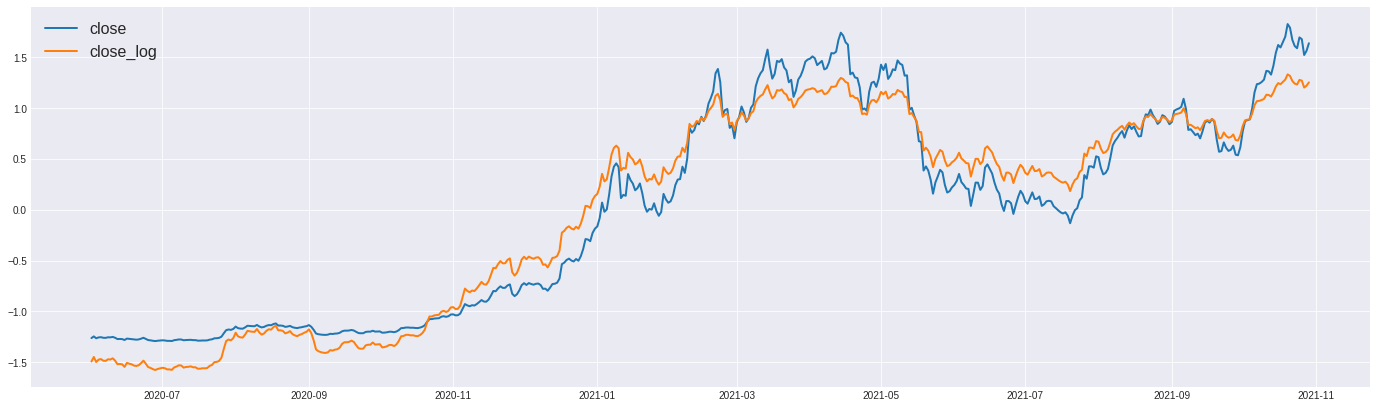

In [23]:
fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(btc['close'], label='close', linewidth=2)
ax.plot(btc['close_log'], label='close_log', linewidth=2)

# ax.plot(btc['ema20'], label='ema20', linewidth=2)
# ax.plot(btc['ema50'], label='ema50', linewidth=2)
# ax.plot(btc['ema100'], label='ema100', linewidth=2)
# ax.plot(btc['ema200'], label='ema200', linewidth=2)
# ax.plot(btc['ema200'], label='ema300', linewidth=2)
# ax.plot(btc['ema300'], label='ema400', linewidth=2)
# ax.plot(btc['ema600'], label='ema600', linewidth=2)
ax.legend(loc='best', fontsize=16)

# fig, ax = plt.subplots(1, figsize=(24, 2))
# ax.plot(btc['diff7'], label='diff7', linewidth=2)
# ax.plot(btc['diff30'], label='diff30', linewidth=2)
# ax.plot(btc['diff60'], label='diff60', linewidth=2)
# ax.plot(btc['diff100'], label='diff100', linewidth=2)
# ax.plot(btc['diff200'], label='diff200', linewidth=2)
# ax.plot(btc['diff400'], label='diff400', linewidth=2)
# ax.plot(btc['diff600'], label='diff600', linewidth=2)
# ax.legend(loc='best', fontsize=16)


# fig, ax = plt.subplots(1, figsize=(24, 7))
# ax.plot(btc['rsi14'], label='rsi14', linewidth=2)
# ax.plot(btc['rsi30'], label='rsi30', linewidth=2)
# ax.plot(btc['rsi60'], label='rsi60', linewidth=2)
# ax.plot(btc['rsi90'], label='rsi90', linewidth=2)
# ax.legend(loc='best', fontsize=16)

# fig, ax = plt.subplots(1, figsize=(24, 2))
# ax.plot(btc['mom10'], label='mom10', linewidth=2)
# ax.plot(btc['mom30'], label='mom30', linewidth=2)
# ax.plot(btc['mom60'], label='mom60', linewidth=2)
# ax.plot(btc['mom90'], label='mom90', linewidth=2)
# ax.legend(loc='best', fontsize=16)



In [35]:
with open('./drive/MyDrive/btc_stan.moh','wb') as f :
    pickle.dump(btc,f)

# creat data lstm

In [36]:
from google.colab import drive
drive.mount('/content/drive')
with open('./drive/MyDrive/btc_stan.moh','rb') as f :
    btc = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
look_back_ = 90
prediction_days = 60
future_ = 30


df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]

In [38]:
df_train_.columns

Index(['close_log', 'close', 'target_log', 'target'], dtype='object')

In [39]:
col = ['close_log', 'close', 'target_log', 'target']
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,close,target_log,target
date,,,,
2021-05-04,1.682984,2.957685,1.690587,2.989399
2021-05-05,1.690587,2.998823,1.703992,3.061692


In [48]:
# # many to one

# from collections import deque
# def dataset_generator_lstm(dataset, look_back=look_back_):
#   sequential_data = [] 
#   prev_days = deque(maxlen=look_back)
#   for i in dataset.values:
#     prev_days.append([n for n in i[:-1]])
#     if len(prev_days) == look_back:  
#       sequential_data.append([np.array(prev_days), i[-1]])
#   dataX=[]
#   dataY=[]
#   for seq, target in sequential_data: 
#     dataX.append(seq) 
#     dataY.append(target) 
#   return np.array(dataX), np.array(dataY)

# trainX, trainY = dataset_generator_lstm(df_train)

# testX, testY = dataset_generator_lstm(df_test)
# # trainX, trainY = trainX[:1740], trainY[:1740]

# futureX, futureY = dataset_generator_lstm(future)

# print("trainX: ", trainX.shape)
# print("trainY: ", trainY.shape)
# print("testX: ", testX.shape)
# print("testY", testY.shape)
# print("futureX: ", futureX.shape)
# print("futureY", futureY.shape)

trainX:  (2016, 90, 3)
trainY:  (2016,)
testX:  (60, 90, 3)
testY (60,)
futureX:  (30, 90, 3)
futureY (30,)


In [49]:
# one to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
  sequential_data = [] 
  sequential_data_log = [] 
  prev_days = deque(maxlen=look_back)
  prev_days_log = deque(maxlen=look_back)

  for i in dataset.values:
    prev_days_log.append(i[0])
    prev_days.append(i[1])

    if len(prev_days) == look_back:  
      sequential_data_log.append([np.array(prev_days), i[-1]])
      sequential_data.append([np.array(prev_days), i[-2]])
      
      
  dataX_log=[]
  dataY_log=[]

  dataX=[]
  dataY=[]

  for seq, target in sequential_data_log: 
    dataX_log.append(seq) 
    dataY_log.append(target) 

  for seq, target in sequential_data: 
    dataX.append(seq) 
    dataY.append(target) 

  dataX_log = tf.expand_dims(dataX_log,axis=2)
  dataX = tf.expand_dims(dataX,axis=2)

  return np.array(dataX_log), np.array(dataY_log), np.array(dataX), np.array(dataY)

trainX_log, trainY_log, trainX, trainY = dataset_generator_lstm(df_train)

testX_log, testY_log, testX, testY = dataset_generator_lstm(df_test)
# trainX, trainY = trainX[:1740], trainY[:1740]

futureX_log, futureY_log, futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("trainX_log: ", trainX_log.shape)
print("trainY_log: ", trainY_log.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("testX_log: ", testX_log.shape)
print("testY_log", testY_log.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)
print("futureX_log: ", futureX_log.shape)
print("futureY_log", futureY_log.shape)

trainX:  (2016, 90, 1)
trainY:  (2016,)
trainX_log:  (2016, 90, 1)
trainY_log:  (2016,)
testX:  (60, 90, 1)
testY (60,)
testX_log:  (60, 90, 1)
testY_log (60,)
futureX:  (30, 90, 1)
futureY (30,)
futureX_log:  (30, 90, 1)
futureY_log (30,)


# train

In [94]:
# batch_size = 60

# regressor = Sequential()

# regressor.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.2))

# regressor.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.3))

# regressor.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
# regressor.add(Dropout(0.4))

# regressor.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
# regressor.add(Dropout(0.2))


# regressor.add(Dense(units = 32, activation = 'relu'))
# regressor.add(Dropout(0.3))

# regressor.add(Dense(units = 1))

input1 = Input(shape=trainX_log.shape[1:])

conv11 = Conv1D(filters=30,kernel_size=30,padding="same",activation="relu")(input1)
conv12 = Conv1D(filters=60,kernel_size=14,padding="same",activation="relu")(input1)
conv13 = Conv1D(filters=90,kernel_size=7,padding="same",activation="relu")(input1)

conv1 = Concatenate(axis=2)([conv11, conv12, conv13])

pool1 = AveragePooling1D(pool_size=61, strides=1, padding="valid", data_format="channels_last")(conv1)

norm1 = BatchNormalization()(pool1)
drop1 = Dropout(rate=0.3)(norm1)

conv21 = Conv1D(filters=90,kernel_size=21,padding="same",activation="relu")(drop1)
conv22 = Conv1D(filters=180,kernel_size=14,padding="same",activation="relu")(drop1)
conv23 = Conv1D(filters=270,kernel_size=7,padding="same",activation="relu")(drop1)

conv2 = Concatenate(axis=2)([conv21, conv22, conv23])

pool2 = AveragePooling1D(pool_size=16, strides=1, padding="valid", data_format="channels_last")(conv2)

norm2 = BatchNormalization()(pool2)
drop2 = Dropout(rate=0.3)(norm2)

conv31 = Conv1D(filters=270,kernel_size=21,padding="same",activation="relu")(drop2)
conv32 = Conv1D(filters=360,kernel_size=14,padding="same",activation="relu")(drop2)
conv33 = Conv1D(filters=450,kernel_size=7,padding="same",activation="relu")(drop2)

conv3 = Concatenate(axis=2)([conv31, conv32, conv33])

pool3 = AveragePooling1D(pool_size=9, strides=1, padding="valid", data_format="channels_last")(conv3)

norm3 = BatchNormalization()(pool3)
drop3 = Dropout(rate=0.3)(norm3)

lstm1 = LSTM(units = 512, activation = 'relu', return_sequences=True)(drop3)

lstm2 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm1)

lstm3 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm2)

lstm4 = LSTM(units = 256, activation = 'relu', return_sequences=True)(lstm3)

lstm5 = LSTM(units = 512, activation = 'relu', return_sequences=True)(lstm4)

flatten = Flatten()(lstm5)
norm4 = BatchNormalization()(flatten)
drop4 = Dropout(rate=0.3)(norm4)

dense1 = Dense(units = 256, activation='relu')(drop4)

norm5 = BatchNormalization()(dense1)
drop5 = Dropout(rate=0.3)(norm5)

dense2 = Dense(units = 64, activation='relu')(drop5)

norm5 = BatchNormalization()(dense2)
drop5 = Dropout(rate=0.2)(norm5)

dense3 = Dense(units = 32, activation='relu')(drop5)

norm6 = BatchNormalization()(dense3)
drop6 = Dropout(rate=0.2)(norm6)

output = Dense(units = 1)(drop6)

model = Model(inputs=input1, outputs=output)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 90, 1)]      0           []                               
                                                                                                  
 conv1d_119 (Conv1D)            (None, 90, 30)       930         ['input_28[0][0]']               
                                                                                                  
 conv1d_120 (Conv1D)            (None, 90, 60)       900         ['input_28[0][0]']               
                                                                                                  
 conv1d_121 (Conv1D)            (None, 90, 90)       720         ['input_28[0][0]']               
                                                                                            

In [95]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


model.compile(optimizer=tf.keras.optimizers.SGD(), loss = 'mean_squared_error')


earlystopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)



In [ ]:
batch_size = 1024

checkpoint_full = ModelCheckpoint(filepath='my_best_model_full.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint_full, earlystopping]

history_full = model.fit(trainX_log, trainY_log, batch_size = batch_size, epochs = 1000, verbose=1, shuffle=False, validation_data=(testX_log, testY_log), callbacks=callbacks)

# checkpoint365 = ModelCheckpoint(filepath='my_best_model_365.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks = [checkpoint365, earlystopping]
# history365 = regressor.fit(trainX[(len(trainY)-365):], trainY[(len(trainY)-365):], batch_size = batch_size, epochs = 50000, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/1000
2/2 [==============================] - ETA: 0s - loss: 2.2644 
Epoch 1: loss improved from inf to 2.26440, saving model to my_best_model_full.hdf5
2/2 [==============================] - 104s 47s/step - loss: 2.2644 - val_loss: 5.4276
Epoch 2/1000
2/2 [==============================] - ETA: 0s - loss: 1.9528 
Epoch 2: loss improved from 2.26440 to 1.95281, saving model to my_best_model_full.hdf5
2/2 [==============================] - 92s 46s/step - loss: 1.9528 - val_loss: 5.4299
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 1.5924 
Epoch 3: loss improved from 1.95281 to 1.59236, saving model to my_best_model_full.hdf5
2/2 [==============================] - 92s 46s/step - loss: 1.5924 - val_loss: 5.4613
Epoch 4/1000


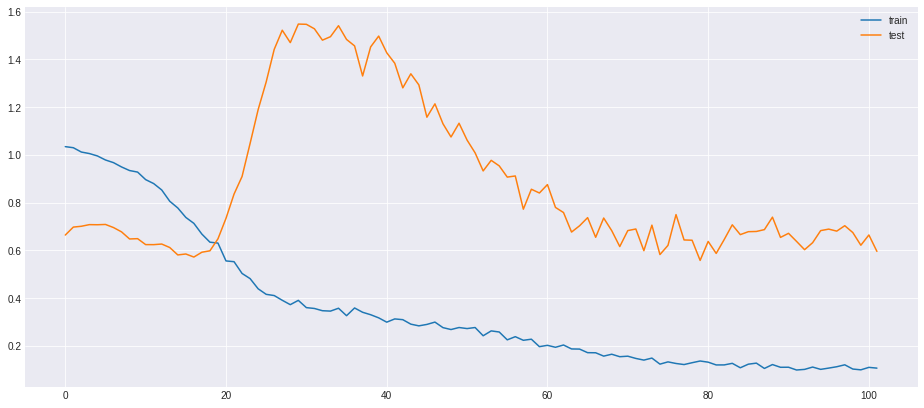

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history_full.history['loss'], label='train')

plt.plot(history_full.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model_full.hdf5')

# test test

In [ ]:
batch_size = 1


model_from_saved_checkpoint = Sequential()


model_from_saved_checkpoint.add(LSTM(units = 256, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
model_from_saved_checkpoint.add(Dropout(0.2))

model_from_saved_checkpoint.add(LSTM(units = 512, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
model_from_saved_checkpoint.add(Dropout(0.3))

model_from_saved_checkpoint.add(LSTM(units = 1024, activation = 'relu', return_sequences=True, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True)) #  dropout=0.25, recurrent_dropout=0.1,
model_from_saved_checkpoint.add(Dropout(0.4))

model_from_saved_checkpoint.add(LSTM(units = 128, activation = 'relu', batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]), stateful=True))
model_from_saved_checkpoint.add(Dropout(0.2))


model_from_saved_checkpoint.add(Dense(units = 32, activation = 'relu'))
model_from_saved_checkpoint.add(Dropout(0.3))

model_from_saved_checkpoint.add(Dense(units = 1))


model_from_saved_checkpoint.load_weights('my_best_model_full.hdf5')
    
model_from_saved_checkpoint.summary()



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (1, 7, 256)               274432    
                                                                 
 dropout_78 (Dropout)        (1, 7, 256)               0         
                                                                 
 lstm_63 (LSTM)              (1, 7, 512)               1574912   
                                                                 
 dropout_79 (Dropout)        (1, 7, 512)               0         
                                                                 
 lstm_64 (LSTM)              (1, 7, 1024)              6295552   
                                                                 
 dropout_80 (Dropout)        (1, 7, 1024)              0         
                                                                 
 lstm_65 (LSTM)              (1, 128)                

In [ ]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = []
for i in testX :
  predicted_btc_price_test_data.append(model_from_saved_checkpoint.predict(np.expand_dims(i, axis=0)))
predicted_btc_price_test_data = scaler_tlog.inverse_transform(np.array(predicted_btc_price_test_data).reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

#test train

In [ ]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = []
for i in trainX :
  predicted_btc_price_train_data.append(model_from_saved_checkpoint.predict(np.expand_dims(i, axis=0)))
predicted_btc_price_train_data = scaler_tlog.inverse_transform(np.array(predicted_btc_price_train_data).reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2363.389


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Train RMSE: %.3f' % rmse_lstm_train)


Train RMSE: 1764.024


## manoal

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### genertor

In [ ]:
look_b.tail(7)

,close_log,close,diff7,diff30,diff60,ema20,ema50,ema100,ema200,ema300,mom10,mom60,target_log
date,,,,,,,,,,,,,
2021-09-23,0.761046,0.663726,-1.158030,-1.417543,2.314176,0.773927,0.733614,0.649180,0.536531,0.368498,-0.366240,1.843266,0.727871
2021-09-24,0.727871,0.609843,-1.324427,-1.499827,1.056508,0.758300,0.728760,0.648401,0.537261,0.370102,-0.836256,0.804859,0.709836
2021-09-25,0.709836,0.579737,-1.631801,-1.403597,1.078098,0.741294,0.722916,0.647041,0.537684,0.371495,-1.276958,0.822685,0.716853
2021-09-26,0.716853,0.591316,-1.448610,-1.450877,0.571209,0.727010,0.717756,0.645938,0.538217,0.372956,-1.298982,0.404167,0.741624
2021-09-27,0.741624,0.631575,-0.464058,-1.562966,0.759889,0.717921,0.714376,0.645653,0.539146,0.374674,-1.078338,0.559952,0.686767
2021-09-28,0.686767,0.542980,-0.311340,-1.911607,0.409429,0.701260,0.707654,0.643620,0.539184,0.375792,-1.554563,0.270592,0.682869
2021-09-29,0.682869,0.536844,-0.372307,-1.790034,-0.133323,0.685601,0.700956,0.641506,0.539161,0.376862,-1.470683,-0.177538,0.732799


In [ ]:
# def rsi():
#   return scaler_rsi.transform(np.array(ta.rsi(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=14))[-1].reshape(-1,1)).reshape(-1,1)

def ema20():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=20))[-1].reshape(-1,1))).reshape(-1,1)

def ema50():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=50))[-1].reshape(-1,1))).reshape(-1,1)

def ema100():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=100))[-1].reshape(-1,1))).reshape(-1,1)

def ema200():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=200))[-1].reshape(-1,1))).reshape(-1,1)

def ema300():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=300))[-1].reshape(-1,1))).reshape(-1,1)


def mom10():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=10))[-1].reshape(-1,1))).reshape(-1,1)

# def mom30():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=30))[-1].reshape(-1,1))).reshape(-1,1)

def mom60():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=60))[-1].reshape(-1,1))).reshape(-1,1)

# def mom90():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=90))[-1].reshape(-1,1))).reshape(-1,1)


# def diff1_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-7].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff30_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-30].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff1(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff7(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-8].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

# def diff20(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-21].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff30(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-31].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

def diff60(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-61].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

#   def diff90(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-91].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d


def close():
  return scaler_t.transform(np.array(np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)))).reshape(-1,1))

###### many to one

In [ ]:
from collections import deque

maxlen = 400
c_log = deque(maxlen=maxlen)

for i in range(-maxlen,0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  c_log.append(look_b['close_log'].values[i])


SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [ ]:
np.array(col).reshape(-1,)

array(['close_log', 'close', 'diff7', 'diff30', 'diff60', 'ema20',
       'ema50', 'ema100', 'ema200', 'ema300', 'mom10', 'target_log'],
      dtype='<U10')

In [ ]:
y_p_ = []
future_len = 30
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.expand_dims(x__, axis=0))

  Close = close()
  # Rsi = rsi()
  Mom10 = mom10()
  # Mom30 = mom30()
  Mom60 = mom60()
  # Mom90 = mom90()
  # Diff1_log = diff1_log()
  # Diff7_log = diff7_log()
  # Diff30_log = diff30_log()
  # Diff1 = diff1()
  Diff7 = diff7()
  # Diff20 = diff20()
  Diff30 = diff30()
  Diff60 = diff60()
  # Diff90 = diff90()
  Ema20 = ema20()
  Ema50 = ema50()
  Ema100 = ema100()
  Ema200 = ema200()
  Ema300 = ema300()

  prev_days.append(np.array([per.reshape(-1,1), Close, Diff7, Diff30, Diff60, Ema20, Ema50, Ema100, Ema200, Ema300, Mom10]).reshape(-1,)) # Diff30, Diff60, Diff90, Mom30, Mom60, Mom90]) # , Diff1_log, Diff7_log, Diff30_log, Diff1, Diff7, Rsi,
  c_log.append(np.array(per).reshape(-1,1))
  y_p_.append(per.reshape(-1,1))


In [ ]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [ ]:
future_actual = scaler_tlog.inverse_transform(futureY.reshape(-1, 1))
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

In [ ]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()